# Statistical Analysis of Brazilian Air Force Aircraft Occurrences

## Project Description

This project's main objective is to carry out a comprehensive statistical analysis of occurrence data involving Brazilian Air Force (FAB) aircraft. The purpose is to answer crucial questions about the profile of aircraft involved in accidents and investigate possible correlations between aircraft age, area factor, type of occurrence.

## Data Description

The aeronautical occurrences database is maintained by the Aeronautical Accident Investigation and Prevention Center (CENIPA). This database covers the period from 2010 to 2021 and comprises the record of aeronautical occurrences reported to CENIPA that occurred in Brazilian territory.

## Methodology

This work will be based on the “Six-step Statistical Investigation Method”.

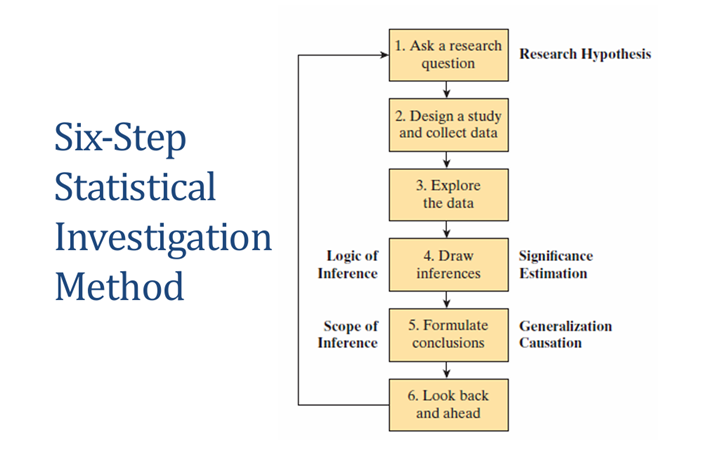

### 1. Research Question

Is the age of an aircraft related to occurrences?

### 2. Study and Data

For the search, we collected data from FAB. More specifically, we worked with four different csv files containing data from "ocorrencias" (occurrences), "tipo de ocorrencia" (type of occurrence), "aeronave" (aircraft) and "fator" (factor).

In [29]:
#!pip install pywaffle -q
#!pip install scikit-posthocs
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scikit_posthocs import posthoc_dunn

In [30]:
# to draw normal distributions

def plot_normal_distribution(z_score, alpha):
    # Set the mean and standard deviation for the normal distribution
    mu = 0  # Mean
    sigma = 1  # Standard Deviation

    left_tail = -stats.norm.ppf(1 - alpha / 2)
    right_tail = stats.norm.ppf(1 - alpha / 2)

    # Determine the x-axis limits based on the provided Z-score and tails
    x_limit_left = -max(abs(z_score) + 0.5, max(abs(left_tail) + 0.5, abs(right_tail) + 0.5))
    x_limit_right = max(abs(z_score) + 0.5, max(abs(left_tail) + 0.5, abs(right_tail) + 0.5))

    # Generate data points for the normal distribution within the updated limits
    x = np.linspace(x_limit_left, x_limit_right, 10000)
    y = stats.norm.pdf(x, mu, sigma)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot the normal distribution
    ax.plot(x, y, label='Normal Distribution')

    # Plot only the blue line (provided Z-score)
    ax.axvline(z_score, color='black', linestyle='--', label=f'Provided Z-Score (Z = {z_score:.2f})')

    ax.fill_between(x, 0, y, color='grey', alpha=0.25, label=f'Non-rejection region')
    ax.fill_between(x, 0, y, where=(x < left_tail), color='red')
    ax.fill_between(x, 0, y, where=(x > right_tail), color='red', label=f'Rejection region for alpha = {alpha}')

    # Set labels and legend
    ax.set_xlabel('Z-Score')
    ax.set_ylabel('Probability Density')
    ax.set_title('Normal Distribution')
    ax.legend(loc="upper left")

    # Show the plot
    plt.show()

In [31]:
def plot_f_test_distribution(f_score, dfn, dfd, alpha=0.05):
    # Calculate the critical F-value for the given alpha
    critical_f_value = stats.f.ppf(1 - alpha, dfn, dfd)

    # Generate data points for the F-distribution
    x = np.linspace(0, max(2 * critical_f_value, f_score + 1), 1000)
    y = stats.f.pdf(x, dfn, dfd)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot the F-distribution
    ax.plot(x, y, label='F-Distribution')

    # Shade the rejection region in red
    x_rejection = np.linspace(critical_f_value, max(2 * critical_f_value, f_score + 1), 100)
    y_rejection = stats.f.pdf(x_rejection, dfn, dfd)
    ax.fill_between(x_rejection, 0, y_rejection, color='red', alpha=0.5, label=f'Rejection Region (α = {alpha})')

    # Mark the critical F-value on the plot
    ax.axvline(f_score, color='black', linestyle='--', label=f'F-score ({f_score:.2f})')

    # Set labels and legend
    ax.set_xlabel('F-Value')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'F-Test Distribution with Rejection Region (α = {alpha})')
    ax.legend()

    # Show the plot
    plt.show()


In [32]:
def plot_chi_square_distribution(chi_statistic, df, alpha):
    # Generate chi-square values from 0 to a high value (adjust if needed)
    x = np.linspace(0, 20, 1000)
    
    # Compute the chi-square probability density function (PDF)
    y = stats.chi2.pdf(x, df)
    
    # Create the rejection region
    rejection_region = stats.chi2.ppf(1 - alpha, df)
    
    # Plot the chi-square PDF
    plt.plot(x, y, label=f'Chi-Square Distribution (df={df})')
    
    # Highlight the rejection region
    plt.fill_between(x, 0, y, where=(x >= rejection_region), color='red', alpha=0.5, label=f'Rejection Region (alpha={alpha})')
    
    # Plot the chi statistic
    plt.axvline(x=chi_statistic, color='black', linestyle='--', label=f'Chi Statistic ({chi_statistic:.2f})')
    
    # Add labels and legend
    plt.xlabel('Chi-Square Value')
    plt.ylabel('Probability Density')
    plt.title('Chi-Square Distribution and Rejection Region')
    plt.legend()
    
    # Show the plot
    plt.show()


In [33]:
def plot_t_student_distribution(t_scores, alpha, df, group_labels):
    
    left_tail = -stats.t.ppf(1 - alpha / 2, df)
    right_tail = stats.t.ppf(1 - alpha / 2, df)

    # Determine the x-axis limits based on the tails
    x_limit_left = min(-left_tail - 0.5, -max(map(abs, t_scores)) - 0.5)
    x_limit_right = max(right_tail + 0.5, max(map(abs, t_scores)) + 0.5)

    # Generate data points for the t-distribution within the updated limits
    x = np.linspace(x_limit_left, x_limit_right, 10000)
    y = stats.t.pdf(x, df)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Define a list of custom colors
    custom_colors = ['b', 'g', 'y', 'k', 'grey', 'orange']

    # Plot the t-distribution
    ax.plot(x, y, label=f't-Distribution (df = {df})')

    # Plot the provided t-scores with custom colors and legends
    for i, t_score in enumerate(t_scores):
        color = custom_colors[i % len(custom_colors)]
        ax.axvline(t_score, color=color, linestyle='--', label=f'{group_labels[i]} (t = {t_score:.2f})')

    ax.fill_between(x, 0, y, color='grey', alpha=0.25, label='Non-rejection region')
    ax.fill_between(x, 0, y, where=(x < left_tail), color='red')
    ax.fill_between(x, 0, y, where=(x > right_tail), color='red', label=f'Rejection region for alpha = {alpha}')

    # Set labels and legend
    ax.set_xlabel('t-Score')
    ax.set_ylabel('Probability Density')
    ax.set_title('t-Student Distribution')
    
    # Place the legend outside the chart
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    
    # Show the plot
    plt.show()

In [34]:
df_ocorrencias = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/ocorrencia.csv', sep=';',  encoding='latin-1')
df_tipo_ocorrencia = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/ocorrencia_tipo.csv', sep=';',  encoding='latin-1')
df_aeronave = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/aeronave.csv', sep=';', encoding='latin-1')
df_fator = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/fator_contribuinte.csv', sep=';',  encoding='latin-1')


In [35]:
df_ocorrencias.set_index('codigo_ocorrencia', inplace=True)
df_tipo_ocorrencia.set_index('codigo_ocorrencia1', inplace=True)
df_aeronave.set_index('codigo_ocorrencia2', inplace=True)
df_fator.set_index('codigo_ocorrencia3', inplace=True)

In [36]:
df = df_ocorrencias.join(df_aeronave).join(df_fator).join(df_tipo_ocorrencia)

In [37]:
df['ocorrencia_ano'] = df['ocorrencia_dia'].apply(lambda x: int(x[-4:]))
df["idade_aeronave"] = df["ocorrencia_ano"] - df["aeronave_ano_fabricacao"]

**Variables to be used**

The variables that will be used for the analysis are:

*   aeronave_ano_fabricacao
*   aeronave_nivel_dano
*   fator_aspecto
*   ocorrencia_classificacao
*   ocorrencia_dia
*   ocorrencia_hora









In [38]:
dados = df[["aeronave_ano_fabricacao", "aeronave_nivel_dano", "aeronave_fatalidades_total", "fator_area", "ocorrencia_classificacao", "ocorrencia_dia", "idade_aeronave", "ocorrencia_longitude", "ocorrencia_latitude", "ocorrencia_hora"]].copy()


**Cleaning Criteria**

Since we have a broad number of occurrences collected (13411), and we are going to work taking samples to implement statistical inferences, there is no problem to simply drop rows with missing values as we continue with a vast number of occurrences.  

Therefore, we will drop the rows with missing values to clean our dataset.

In [39]:
dados.dropna(inplace=True)
dados = dados[dados['aeronave_ano_fabricacao'] > 0]
dados = dados[dados['aeronave_nivel_dano'] != "***"]


**Collecting INMET Data**

We also extended our dataset with data from the National Institute of Meteorology (INMET) to retrieve weather data during the occurrences, so that we could analyze how the wind may impact aircraft incidents.






In [40]:
dados['timestamp'] = pd.to_datetime(dados['ocorrencia_dia'] + ' ' + dados['ocorrencia_hora'], format='%d/%m/%Y %H:%M:%S').dt.floor('H')

In [41]:
# dados[["ocorrencia_longitude", "ocorrencia_latitude", "ocorrencia_dia", "ocorrencia_hora" , "timestamp"]]

In [42]:
import requests

def get_weather_data(latitude, longitude, timestamp):

    base_url = "https://archive-api.open-meteo.com/v1/archive"
    hourly = "temperature_2m,rain,weathercode,windspeed_100m"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": timestamp.strftime("%Y-%m-%d"),
        "end_date": timestamp.strftime("%Y-%m-%d"),
        "hourly": hourly
    }

    response = requests.get(base_url, params=params)
    weather_data = response.json()
    weather = pd.DataFrame(weather_data['hourly'])
    weather["timestamp"] = pd.to_datetime(weather["time"])
    # You can set 'time' as the index if needed:
    weather.set_index('timestamp', inplace=True)
    # Now you have a DataFrame with the provided data
    if response.status_code == 200:
        return weather.loc[timestamp]
    else:
        # Handle errors here, e.g., raise an exception or return an error message
        return f"Error: {response.status_code}"

In [43]:
year = "2022"
filtered_df = dados[dados['ocorrencia_dia'].apply(lambda x: x[-4:]) == year]
filtered_df = dados[dados["ocorrencia_latitude"] != "***"]
filtered_df = filtered_df[filtered_df["ocorrencia_longitude"] != "***"]

Getting weather data for every accident in DataFrame

In [46]:
df_weather = pd.read_csv("weather.csv", index_col=0).drop_duplicates()
df_weather.head()

,aeronave_ano_fabricacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_area,ocorrencia_classificacao,ocorrencia_dia,idade_aeronave,ocorrencia_longitude,ocorrencia_latitude,ocorrencia_hora,timestamp,rain,windspeed_100m
45331,2001.0,NENHUM,0.0,FATOR OPERACIONAL,ACIDENTE,06/01/2012,11.0,-46.473056,-23.435556,13:44:00,2012-06-01 13:00:00,0.0,11.4
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.473056,-23.435556,13:44:00,2012-06-01 13:00:00,0.0,11.4
45390,1989.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,20/01/2012,23.0,-49.443056,-18.431944,21:00:00,2012-01-20 21:00:00,0.1,2.9
45392,2000.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,19/01/2012,12.0,-47.874722,-15.819722,21:30:00,2012-01-19 21:00:00,0.3,10.6
45393,1967.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,22/01/2012,45.0,-43.370000,-22.987500,20:25:00,2012-01-22 20:00:00,0.0,25.5


### 3. Exploratory data analysis (EDA)

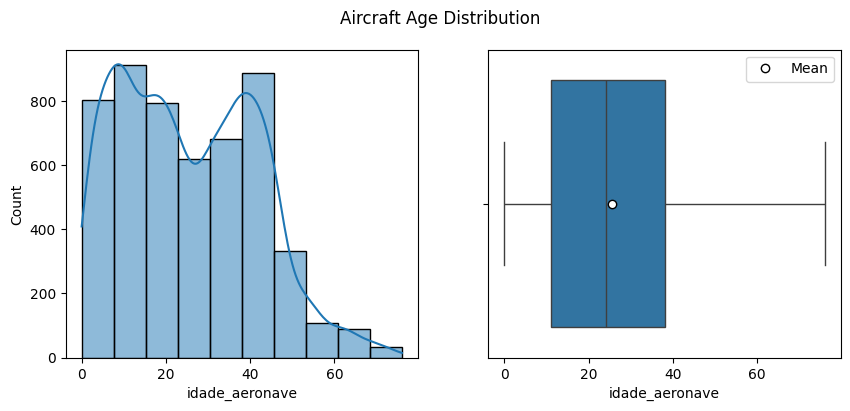

In [47]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
sns.histplot(data=dados, x="idade_aeronave", kde=True, bins=10, ax=axs[0])
sns.boxplot(data=dados, x="idade_aeronave", ax=axs[1],
            showmeans=True,
            meanprops={"marker": "o",
                       "markeredgecolor": "black",
                       "markersize": "6",
                       "markerfacecolor": "w"
                       }
            )
plt.legend(handles=[plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="w", markersize=6, markeredgecolor="black", label="Mean")])
fig.suptitle("Aircraft Age Distribution")
plt.show()

In [48]:
dados.describe()

,aeronave_ano_fabricacao,aeronave_fatalidades_total,idade_aeronave,timestamp
count,5258.000000,5258.000000,5258.000000,5258
mean,1990.858692,0.629897,25.534994,2016-11-15 04:04:14.697603584
min,1945.000000,0.000000,0.000000,2012-01-06 13:00:00
25%,1977.000000,0.000000,11.000000,2014-02-19 17:00:00
50%,1992.000000,0.000000,24.000000,2016-11-19 21:00:00
75%,2006.000000,0.000000,38.000000,2019-05-05 22:30:00
max,2021.000000,10.000000,76.000000,2022-12-07 14:00:00
std,16.222558,1.454515,16.230823,NaN


#### Explaining what is considered new and old aircrafts​

* We discretized aircraft ages into quartiles to distinguish between new and old airplanes.

* After obtaining [11, 24, 38] for the [25%, 50%, 75%] quantiles respectively, we decided that new airplanes are those with an age less than or equal to 11, which corresponds to the first quartile (25%). Conversely, old aircraft are those with an age greater than 11.

* We chose to use quartiles because it allows for a roughly equal distribution of occurrences in each discretized interval, as illustrated in the chart on the following slide.

In [49]:
q1= dados[dados["idade_aeronave"] <= 11]
q2= dados[dados["idade_aeronave"].between(12, 24)]
q3= dados[dados["idade_aeronave"].between(25,38)]
q4= dados[dados["idade_aeronave"] > 38]
q234 = dados[dados["idade_aeronave"] > 11]

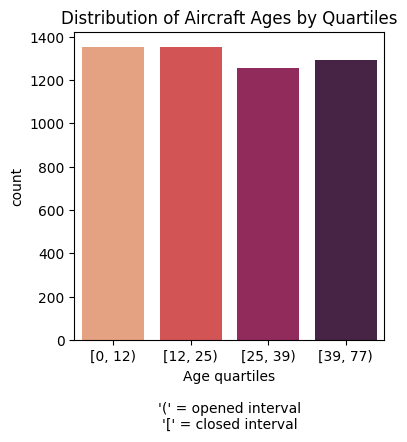

In [50]:
quartis = [0, 12, 25, 39, 77]

# Cria uma nova coluna 'quartis_idade' baseada nos limites
dados['quartis_idade'] = pd.cut(dados['idade_aeronave'], bins=quartis, right=False)

plt.figure(figsize=(4,4))
sns.countplot(data=dados, x="quartis_idade", palette="rocket_r")
plt.xlabel("Age quartiles\n\n'(' = opened interval\n'[' = closed interval")
plt.title("Distribution of Aircraft Ages by Quartiles")
plt.show()


#### Analyzing the wind distribution for new and old aircraft

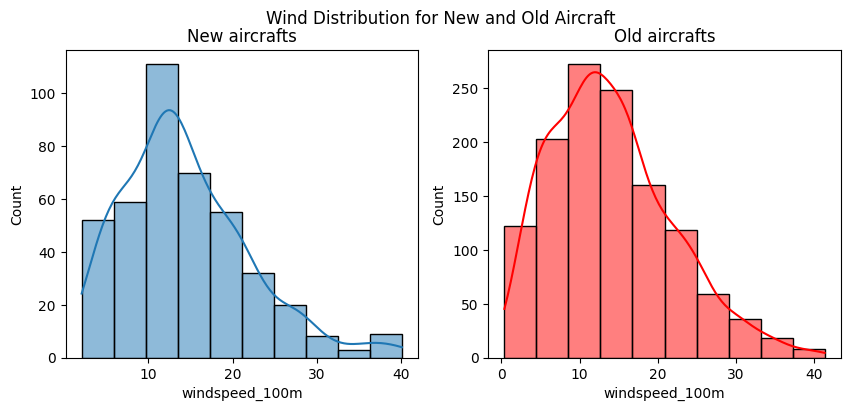

In [51]:
new = df_weather[df_weather["idade_aeronave"] <= 11].drop_duplicates()
old = df_weather[df_weather["idade_aeronave"] > 11].drop_duplicates()

fig, axs = plt.subplots(1,2, figsize=(10, 4))
sns.histplot(data=new, x="windspeed_100m", kde=True, bins=10, ax=axs[0])
axs[0].set_title("New aircrafts")
sns.histplot(data=old, x="windspeed_100m", kde=True, bins=10, ax=axs[1], color='r')
axs[1].set_title("Old aircrafts")
fig.suptitle("Wind Distribution for New and Old Aircraft")
plt.show()

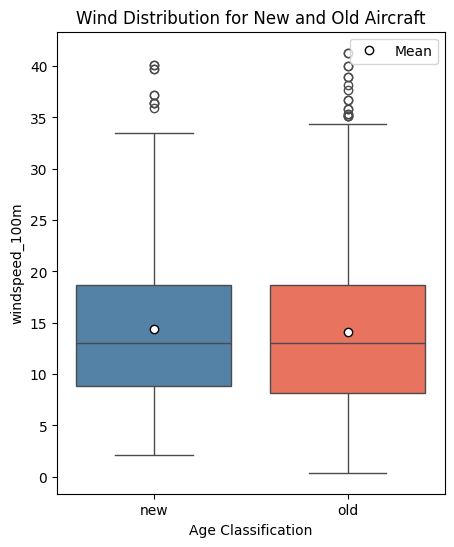

In [52]:
df_weather["classificacao_idade"] = "new"
df_weather.loc[df_weather["idade_aeronave"] > 11, "classificacao_idade"] = "old"

plt.figure(figsize=(5, 6))
sns.boxplot(data=df_weather, y="windspeed_100m", x="classificacao_idade", showfliers=True, palette={"new": "steelblue", "old": "tomato"},
            showmeans=True,
            meanprops={"marker": "o",
                       "markeredgecolor": "black",
                       "markersize": "6",
                       "markerfacecolor": "w"
                       }
            )
plt.legend(handles=[plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="w", markersize=6, markeredgecolor="black", label="Mean")])
plt.xlabel("Age Classification")
plt.title("Wind Distribution for New and Old Aircraft")
plt.show()


#### Damage Level Analysis

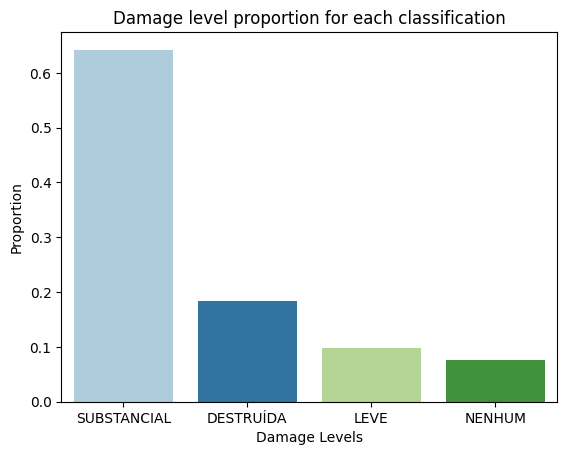

In [53]:
sns.barplot(x=dados["aeronave_nivel_dano"].value_counts(normalize=True).index,
             y=dados["aeronave_nivel_dano"].value_counts(normalize=True),
             palette="Paired"
            )
plt.title("Damage level proportion for each classification")
plt.ylabel("Proportion")
plt.xlabel("Damage Levels")
plt.show()

In [54]:
proportions_damage_age = pd.crosstab(dados["quartis_idade"], dados["aeronave_nivel_dano"], normalize="index")
proportions_damage_age

aeronave_nivel_dano,DESTRUÍDA,LEVE,NENHUM,SUBSTANCIAL
quartis_idade,,,,
"[0, 12)",0.158050,0.119645,0.147710,0.574594
"[12, 25)",0.227811,0.119822,0.066568,0.585799
"[25, 39)",0.163752,0.093800,0.042925,0.699523
"[39, 77)",0.187017,0.054096,0.042504,0.716383


In [55]:
long_p_damage_age = pd.melt(proportions_damage_age.reset_index(), id_vars=['quartis_idade'], value_vars=proportions_damage_age.columns.tolist(), var_name='Nivel', value_name='Proportion').sort_values(by="Proportion", ascending=False)
# long_p_damage_age

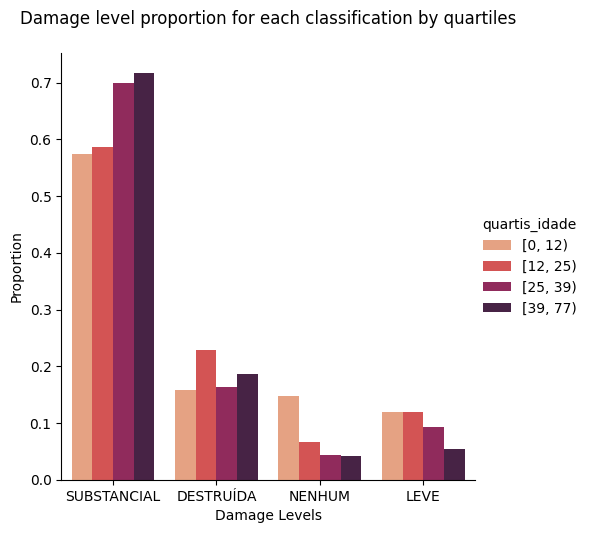

In [56]:
sns.catplot(data=long_p_damage_age, x="Nivel", y="Proportion", hue="quartis_idade", kind="bar", palette="rocket_r")
plt.title("Damage level proportion for each classification by quartiles\n")
plt.ylabel("Proportion")
plt.xlabel("Damage Levels")
plt.show()

#### Analysis of the type of occurrence

In [57]:
proportions_type_age = pd.crosstab(dados["quartis_idade"], dados["ocorrencia_classificacao"], normalize="index")
proportions_type_age

ocorrencia_classificacao,ACIDENTE,INCIDENTE,INCIDENTE GRAVE
quartis_idade,,,
"[0, 12)",0.741507,0.019941,0.238552
"[12, 25)",0.789941,0.005178,0.204882
"[25, 39)",0.844992,0.006359,0.148649
"[39, 77)",0.891808,0.000000,0.108192


In [58]:
long_p_type_age = pd.melt(proportions_type_age.reset_index(), id_vars=['quartis_idade'], value_vars=proportions_type_age.columns.tolist(), var_name='type_of_occurrence', value_name='Proportion').sort_values(by="Proportion", ascending=False)
# long_p_type_age

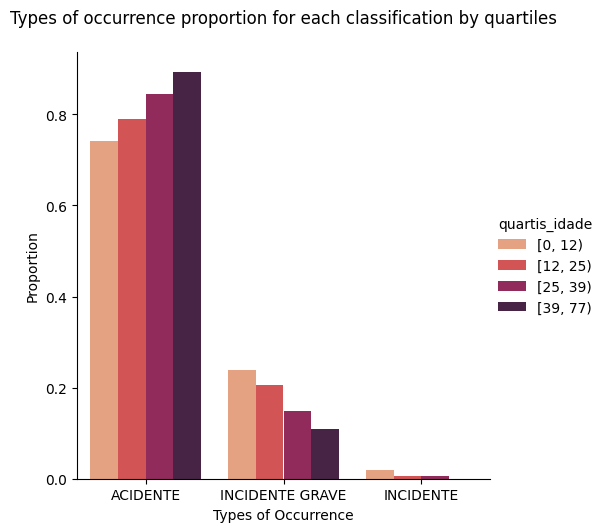

In [59]:
sns.catplot(data=long_p_type_age, x="type_of_occurrence", y="Proportion", hue="quartis_idade", kind="bar", palette="rocket_r")
plt.title("Types of occurrence proportion for each classification by quartiles\n")
plt.ylabel("Proportion")
plt.xlabel("Types of Occurrence")
plt.show()

#### Analysis of the type of occurrence for old and new aircraft

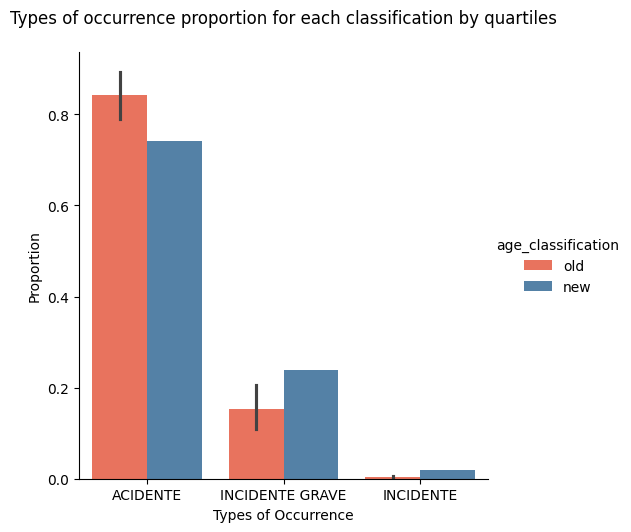

In [60]:
long_p_type_age["age_classification"] = "new"
long_p_type_age.loc[~(long_p_type_age["quartis_idade"] == pd.Interval(quartis[0], quartis[1], closed='left')), "age_classification"] = "old"
sns.catplot(data=long_p_type_age, x="type_of_occurrence", y="Proportion", hue="age_classification", kind="bar", palette={"new": "steelblue", "old": "tomato"})
plt.title("Types of occurrence proportion for each classification by quartiles\n")
plt.ylabel("Proportion")
plt.xlabel("Types of Occurrence")
plt.show()

#### Incident analysis by factor

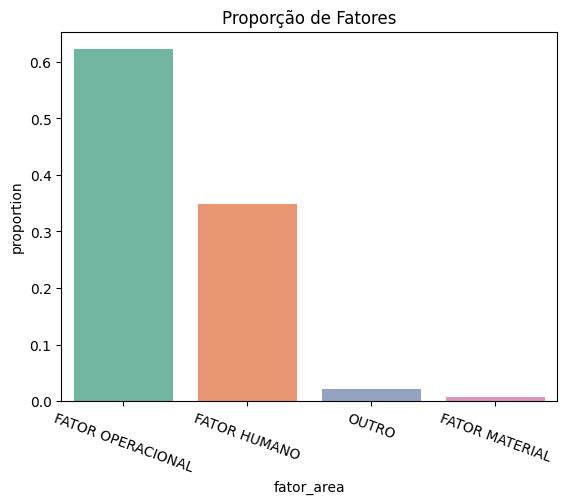

In [61]:
sns.barplot(x=dados["fator_area"].value_counts(normalize=True).index,
             y=dados["fator_area"].value_counts(normalize=True),
             palette="Set2"
            )
plt.title("Proporção de Fatores")
plt.xticks(rotation=-20)
plt.show()

#### Correlation matrix between Aircraft age and Area Factor

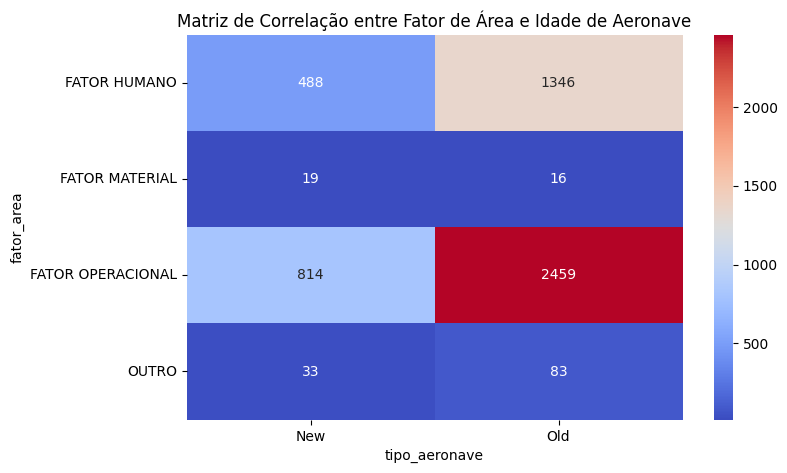

In [62]:
# Cria uma coluna para identificar se a aeronave é nova ou velha
dados['tipo_aeronave'] = ['New' if q == pd.Interval(quartis[0], quartis[1], closed='left') else 'Old' for q in dados['quartis_idade']]

# Calcula a matriz de correlação
correlation_matrix = dados.groupby(['fator_area', 'tipo_aeronave']).size().unstack().fillna(0)

# Plota o heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='g')
plt.title('Matriz de Correlação entre Fator de Área e Idade de Aeronave')
plt.show()


### 4. Drawing Inferences

Analyzing the charts we can propose the hypothesis:


1.  Is there a difference between the proportion of accidents in aircraft older than 11 years than on aircraft newer than 11 years? If so, does this difference go in which direction? 
2.  Is there differences among the averages of airplanes in each damage level? If so, between which ones and in which direction?
3.  Is proportion of airplanes with greater than or equal 11 years which had substantial damage in the occurrences significantly greater than proportion of airplanes with less than 11 years?
4.  Is there a significant relationship between the occurrence factor and the age of the aircraft? 
5.  Are older aircraft more susceptible to accidents due to wind speed?





#### 4.1

**Checking Hypothesis**

> Is there a difference between the proportion of accidents in aircraft older than 11 years than on aircraft newer than 11 years? If so, does this difference go in which direction?



**Hypothesis Formulation**
- $H_0$ = There's no difference between the proportion of accidents in aircraft older than 11 years than on aircraft newer than or equal 11 years
    > $p_{>11} - p_{<=11} = 0$


- $H_A$ = There's a difference between the proportion of accidents in aircraft older than 11 years than in aircraft newer than or equal 11 years
    > $p_{>11} - p_{<=11} ≠ 0$



**Checking conditions for the sampling distribution of $p̂_1$ − $p̂_2$ to be normal:**



1.   **Independence**

* Because the data come from a simple random sample,
the observations are independent, both within and between samples.

2.   **Success-failure condition**

* Since the null hypothesis is that the proportions are equal, we use the pooled proportion ($p̂_{pooled}$)
to verify the success-failure condition and estimate the standard error.
* $p̂_{pooled} = \frac{{p̂_1 n_1 + p̂_2 n_2}}{{n_1 + n_2 }}$
* $n_1 * p̂_{pooled} \geq 10$ and $n_1 * (1-p̂_{pooled}) \geq 10$
* $n_2 * p̂_{pooled} \geq 10$ and $n_2 * (1-p̂_{pooled}) \geq 10$

In [63]:
# Given data
SAMPLE_SIZE_ACCIDENTS = 150

sample_new = dados[dados["tipo_aeronave"] == "New"].sample(n=SAMPLE_SIZE_ACCIDENTS, replace=False, axis=0)
sample_old = dados[dados["tipo_aeronave"] == "Old"].sample(n=SAMPLE_SIZE_ACCIDENTS, replace=False, axis=0)

accident_proportions_new = sample_new.ocorrencia_classificacao.value_counts(normalize=True)
accident_proportions_old = sample_old.ocorrencia_classificacao.value_counts(normalize=True)

confidence_level = 0.95

# Using the pooled proportion when H0 is p1-p2 = 0
p_pooled= (accident_proportions_new.ACIDENTE * SAMPLE_SIZE_ACCIDENTS + \
            accident_proportions_old.ACIDENTE * SAMPLE_SIZE_ACCIDENTS) / \
            (SAMPLE_SIZE_ACCIDENTS + SAMPLE_SIZE_ACCIDENTS)
print(f"For n(>11) = {SAMPLE_SIZE_ACCIDENTS}\n"
        f"    n(<=11) = {SAMPLE_SIZE_ACCIDENTS}\n\n"
        f"p̂_>11 (accidents) = {accident_proportions_old.ACIDENTE}\n"
        f"p̂_<=11 (accidents) = {accident_proportions_new.ACIDENTE}\n"
        f"p̂_pooled (accidents) = {p_pooled}"
    )


For n(>11) = 150
    n(<=11) = 150

p̂_>11 (accidents) = 0.9
p̂_<=11 (accidents) = 0.7533333333333333
p̂_pooled (accidents) = 0.8266666666666667


In [64]:
ck1 = p_pooled * SAMPLE_SIZE_ACCIDENTS
ck2 = (1 - p_pooled) * SAMPLE_SIZE_ACCIDENTS

if ck1 >= 10 and ck2 >= 10:
    print("Conditions 𝑛1 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛1 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

ck3 = p_pooled * SAMPLE_SIZE_ACCIDENTS
ck4 = (1 - p_pooled) * SAMPLE_SIZE_ACCIDENTS

if ck3 >= 10 and ck4 >= 10:
    print("Conditions 𝑛2 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛2 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

Conditions 𝑛1 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!
Conditions 𝑛2 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!


**As both conditions are satisfied, we can safely model the difference in proportions using a normal distribution!**

**Standard error for the difference of proportions**


$SE = \sqrt{\frac{{(p̂_{pooled} * (1-p̂_{pooled})}}{{n_{\gt 11}}} + \frac{{(p̂_{pooled} * (1-p̂_{pooled})}}{{n_{\leq 11}}}}$

In [65]:
# Calculate the standard error
standard_error_accident = np.sqrt(
    ((p_pooled * (1 - p_pooled)) / SAMPLE_SIZE_ACCIDENTS) # Newer SE
    +
    ((p_pooled * (1 - p_pooled)) / SAMPLE_SIZE_ACCIDENTS) # Older SE
)

print("SE =", standard_error_accident)

SE = 0.04370947858895732


**Point Estimate**

$point \ estimate = 𝑝̂_{\gt 11} - 𝑝̂_{\leq 11}$

In [66]:
#Point estimate
point_estimate_accident = accident_proportions_old.ACIDENTE - accident_proportions_new.ACIDENTE
print("point_estimate =", point_estimate_accident)

point_estimate = 0.14666666666666672


**Null Value**

In [67]:
null_value_accident = 0     # it comes from the null hypothesis, since we are considering the difference between proportions 0
print("Null value =", null_value_accident)
print("It comes from the null hypothesis, since we are considering the difference between proportions 0")

Null value = 0
It comes from the null hypothesis, since we are considering the difference between proportions 0


**Test Statistic**

$Z^{*} = \frac{{\text{point estimate} - \text{null value}}}{{SE}}$

In [68]:
z_score_accident = (point_estimate_accident - null_value_accident) / standard_error_accident
print("Test statistic (Z*) =", z_score_accident)

Test statistic (Z*) = 3.3554888184760983


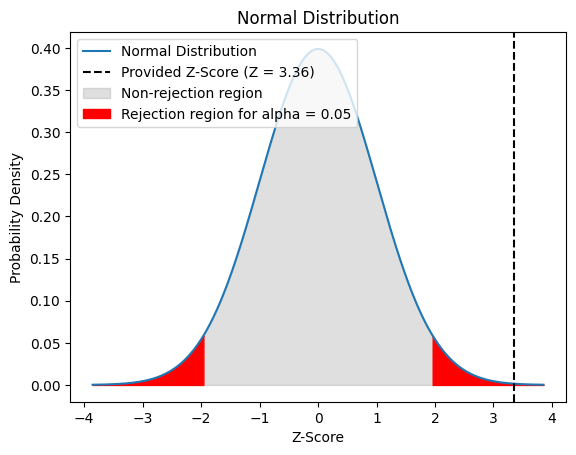

In [69]:
plot_normal_distribution(z_score_accident, alpha=0.05)

In [70]:
p_value = stats.norm.sf(abs(z_score_accident)) * 2
alpha = 0.05

if p_value < alpha:
    print(f"For a p-value = {p_value} and alpha = {alpha} we REJECT the null hypothesis!")
else:
    print(f"For a p-value = {p_value} and alpha = {alpha} we DO NOT REJECT the null hypothesis!")

For a p-value = 0.0007922485913106378 and alpha = 0.05 we REJECT the null hypothesis!


**Confidence Interval**

In [71]:
z_critical = stats.norm.ppf(1 - alpha / 2)

# Calculate the margin of error for the confidence interval
margin_of_error_accident = z_critical * standard_error_accident

confidence_interval_lower_accident = point_estimate_accident - margin_of_error_accident
confidence_interval_upper_accident = point_estimate_accident + margin_of_error_accident

confidence_interval_accident = (confidence_interval_lower_accident , confidence_interval_upper_accident)
print(f"Since the confidence interval {confidence_interval_accident} do not have 0, \nthere is additional evidence to reject the null hypothesis")


Since the confidence interval (0.06099766284928575, 0.23233567048404768) do not have 0, 
there is additional evidence to reject the null hypothesis


In [72]:
def to_percentual_points(n):
  return round(n*100, 2)
print(f"We can confirm with a {confidence_level * 100}% confindence level that older aircrafts \ntend to have\
 {to_percentual_points(confidence_interval_lower_accident)}PP to {to_percentual_points(confidence_interval_upper_accident)}PP more accidents than newer ones")

We can confirm with a 95.0% confindence level that older aircrafts 
tend to have 6.1PP to 23.23PP more accidents than newer ones


#### 4.2 ANOVA TEST

**Checking Hypothesis**
> Is there differences among the averages of airplanes in each damage level? If so, between which ones and in which direction?

**Age Distribution Per Damage Level**

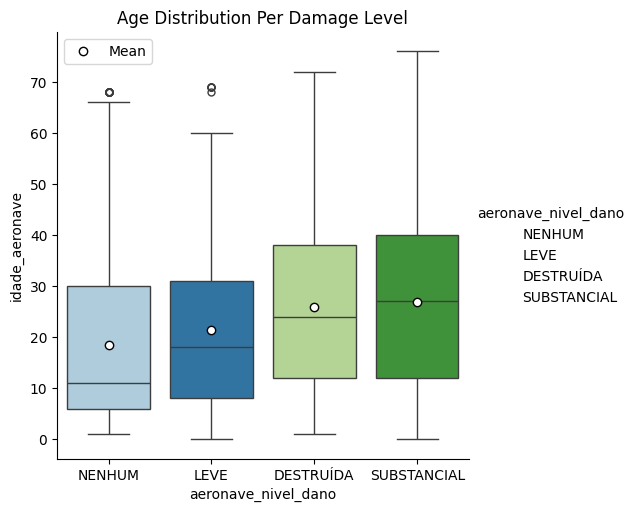

In [73]:
order_by_median = dados.groupby("aeronave_nivel_dano")["idade_aeronave"].median().sort_values().index
sns.catplot(data=dados, x="aeronave_nivel_dano", y="idade_aeronave", kind="box", palette="Paired", order=order_by_median,
            showmeans=True,
            meanprops={"marker": "o",
                       "markeredgecolor": "black",
                       "markersize": "6",
                       "markerfacecolor": "w"
                       }
            )
plt.legend(handles=[plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="w", markersize=6, markeredgecolor="black", label="Mean")])
plt.title("Age Distribution Per Damage Level")
plt.show()

We can even think if there is difference between the averages of ages for each category of damage level. To check this, we will use ANOVA.

**Hypothesis Formulation**

$H_0:$ There IS NO difference between the averages of airplanes ages for each category of damage level.


> $μ_{NENHUM}=μ_{SUBSTANCIAL}=μ_{LEVE}=μ_{DESTRUIDA}$

$H_A$: The average of airplane ages (µ) varies across some (or all) groups.

In [117]:
SAMPLE_SIZE_ANOVA = 250

sample_category_none = dados[dados["aeronave_nivel_dano"] == "NENHUM"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)
sample_category_light = dados[dados["aeronave_nivel_dano"] == "LEVE"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)
sample_category_substancial = dados[dados["aeronave_nivel_dano"] == "SUBSTANCIAL"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)
sample_category_destructed = dados[dados["aeronave_nivel_dano"] == "DESTRUÍDA"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)
ages_none = sample_category_none["idade_aeronave"]
ages_light = sample_category_light["idade_aeronave"]
ages_substantial = sample_category_substancial["idade_aeronave"]
ages_destructed = sample_category_destructed["idade_aeronave"]

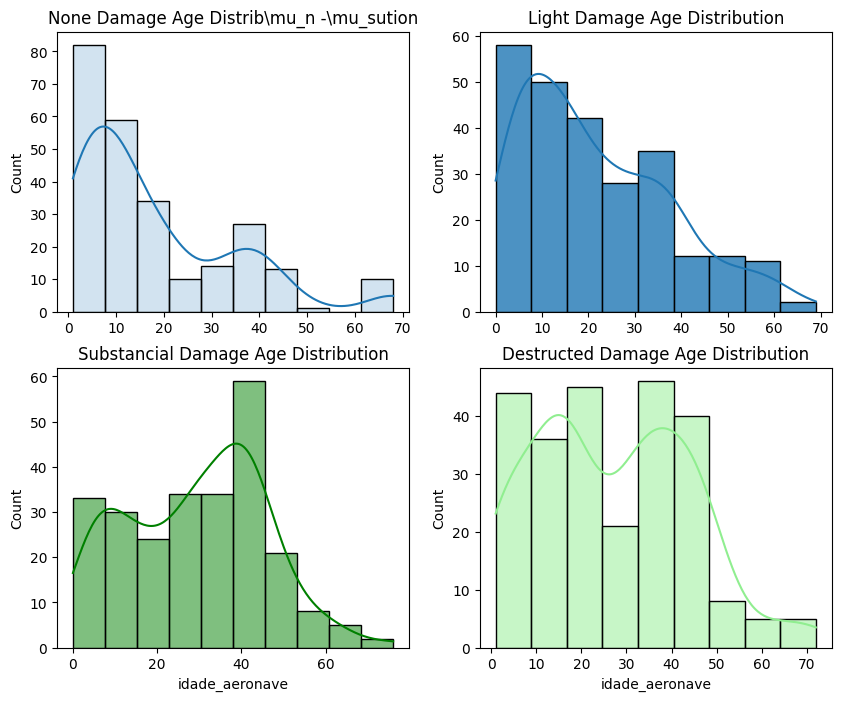

None Normality check:
ShapiroResult(statistic=0.8458277583122253, pvalue=4.612467092296457e-15)

Light Normality check:
ShapiroResult(statistic=0.9286033511161804, pvalue=1.273294358838939e-09)

Substancial Normality check:
ShapiroResult(statistic=0.9675104022026062, pvalue=1.8406139133730903e-05)

Destructed Normality check:
ShapiroResult(statistic=0.9591130614280701, pvalue=1.5696309674240183e-06)



In [118]:
fig, axs = plt.subplots(2,2, figsize=(10,8))

sns.histplot(data=sample_category_none, x="idade_aeronave", kde=True, ax=axs[0,0], alpha=0.2)
axs[0,0].set_title("None Damage Age Distrib\mu_n -\mu_sution")
axs[0,0].set_xlabel("")

sns.histplot(data=sample_category_light, x="idade_aeronave", kde=True, ax=axs[0,1], alpha=0.8)
axs[0,1].set_title("Light Damage Age Distribution")
axs[0,1].set_xlabel("")

sns.histplot(data=sample_category_substancial, x="idade_aeronave", kde=True, ax=axs[1,0], color="green")
axs[1,0].set_title("Substancial Damage Age Distribution")

sns.histplot(data=sample_category_destructed, x="idade_aeronave", kde=True, ax=axs[1,1], color="lightgreen")
axs[1,1].set_title("Destructed Damage Age Distribution")

plt.show()

print(f"None Normality check:\n{stats.shapiro(ages_none)}\n")
print(f"Light Normality check:\n{stats.shapiro(ages_light)}\n")
print(f"Substancial Normality check:\n{stats.shapiro(ages_substantial)}\n")
print(f"Destructed Normality check:\n{stats.shapiro(ages_destructed)}\n")

**Variance for each category**

In [119]:
print(f"Variances for each damage level for n1 = n2 = n3 = n4 = {SAMPLE_SIZE_ANOVA}\n")
print("None damage variance:", np.std(sample_category_none["idade_aeronave"]) ** 2)
print("Light damage variance:", np.std(sample_category_light["idade_aeronave"]) ** 2)
print("Substancial damage variance:", np.std(sample_category_substancial["idade_aeronave"]) ** 2)
print("Destructed damage variance:", np.std(sample_category_destructed["idade_aeronave"]) ** 2)
print()
print("Testing if variances are not equal:")
levene_result = stats.levene(ages_destructed, ages_none, ages_light, ages_substantial)
print(levene_result)
print()
if levene_result.pvalue > 0.05:
    print("The test is not significant (p-value > 0.05), \nmeaning that there is homogeneity of variances and we can proceed with ANOVA.")
else:
    print("The test is significant (p-value < 0.05), \nmeaning that there is no homogeneity of variances and we cannot proceed with ANOVA.")

Variances for each damage level for n1 = n2 = n3 = n4 = 250

None damage variance: 275.98969600000004
Light damage variance: 258.46521600000005
Substancial damage variance: 271.034576
Destructed damage variance: 294.67225600000006

Testing if variances are not equal:
LeveneResult(statistic=2.5226443667868783, pvalue=0.05646113408705897)

The test is not significant (p-value > 0.05), 
meaning that there is homogeneity of variances and we can proceed with ANOVA.


**Checking conditions to apply ANOVA**


1.  **Independence between and within each category**
* Since we are taking simple random samples, this condition is checked.
2.   **Approximately normal distribution of each group**
* We can check looking at the charts and at the shapiro tests that the normality is not so approximated. However, we will relax this point to apply ANOVA and confirm in the results found in the end with Kruskal-Wallis test, a more appropriate one for this case.
3. **Constant variance comparing the groups**
* We can consider the variances for each category approximately equal, for this taken sample.



Relaxing the point 2 above, we will apply ANOVA to check if there are differences between the average ages across the 4 groups.

**Applying ANOVA (F-test) for 0.05 significance level**

In [77]:
from scipy.stats import f_oneway, kruskal

alpha_anova = 0.05
f_score, p_value_anova = f_oneway(ages_none, ages_light, ages_substantial, ages_destructed)
print(f"F-score gotten: {f_score}\n")

if p_value_anova < alpha_anova:
    print(f"For a p-value = {p_value_anova} and alpha = {alpha_anova} we REJECT the null hypothesis!")
else:
    print(f"For a p-value = {p_value_anova} and alpha = {alpha_anova} we DO NOT REJECT the null hypothesis!")

F-score gotten: 17.209769061785043

For a p-value = 6.693471039982583e-11 and alpha = 0.05 we REJECT the null hypothesis!


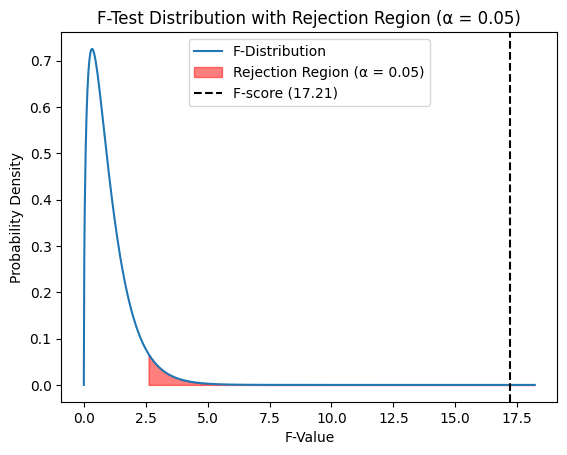

In [78]:
k = len(dados["aeronave_nivel_dano"].unique())
dfg = k - 1
dfe = k * SAMPLE_SIZE_ANOVA - k

plot_f_test_distribution(f_score, dfg, dfe, alpha=0.05)

**First Conclusion**

As we rejected the null hypothesis, we can conclude that there are differences between the averages of ages among the damage levels.

However, **we still do not know which levels are different from others**. To do that, we will apply the t-test with some modifications for each pair of categories and check which pairs reject the null hypothesis.

**Applying BONFERRONI correction for 𝛂**

$\alpha^*_{BONFERRONI} = \frac{\alpha}{number \ of \ pairs \ to \ compare}$ 

In [79]:
k = len(dados["aeronave_nivel_dano"].unique())
number_of_pairs = k * (k - 1) / 2
alpha_bonferroni = alpha_anova / number_of_pairs

print(f"Number of pairs to compare = {int(number_of_pairs)}")
print(f"α*(Bonferroni) = {alpha_bonferroni}")

Number of pairs to compare = 6
α*(Bonferroni) = 0.008333333333333333


$df_G = k - 1$

$df_E = (\sum_{i = 1}^k n_i) - k$

Where k is the number of different categories being analyzed (4) 
and $n_i$ is the sample size for each category. 

In [80]:
dfg = k - 1
dfe = k * SAMPLE_SIZE_ANOVA - k

print(f"dfG = {dfg}")
print(f"dfE = {dfe}")

dfG = 3
dfE = 996


**Comparing each pair**

**Standard error for the difference of means**

$SE=\sqrt{\frac{s_{pooled^2}}{n_1}+\frac{s_{pooled^2}}{n_2}}$

**Test statistic**

$t^*= \frac{{\text{point estimate} - \text{null value}}}{{SE}}$

**Significance level we will use**

$\alpha* (Bonferroni) = 0.0083$

In [81]:
all_anova_samples = pd.concat([sample_category_none, sample_category_light,
                               sample_category_substancial, sample_category_destructed], axis=0)
s_pooled = np.std(all_anova_samples["idade_aeronave"])
print("Standard deviation pooled for all taken samples:")
print("s_pooled =", s_pooled)

Standard deviation pooled for all taken samples:
s_pooled = 16.485559256512957


**Hypothesis Formulation for applying t-test for each pair of damage level**

For each pair being evaluated using the t-test with the BONFERRONI correction we are stating the following hypothesis: 

$H_0:$ There IS NO difference between the averages of airplanes ages damage level x and damage level y.
> $μ_x - μ_y = 0$

$H_A$: There IS difference between the averages of airplanes ages damage level x and damage level y.
> $μ_x - μ_y ≠ 0$


where x and y $\in$ {NONE, LIGHT, SUBSTANTIAL, DAMAGE} and x ≠ y 

In [82]:
damage_levels = ['none', 'light', 'substantial', 'destructed']
anova_samples = [sample_category_none["idade_aeronave"],
                 sample_category_light["idade_aeronave"],
                 sample_category_substancial["idade_aeronave"],
                 sample_category_destructed["idade_aeronave"]
                 ]
t_scores = []
pairs = []

null_value_anova = 0

# comparing all pairs
for i in range(k):
    for j in range(i + 1, k):
        level1, level_sample1 = damage_levels[i], anova_samples[i]
        level2, level_sample2 = damage_levels[j], anova_samples[j]
        pairs.append(f"({level1}, {level2})")
        print(f"Pair ({level1}, {level2}):")

        avg1 = np.mean(level_sample1)
        print(f"    x̄1 ({level1} damage level):", avg1)

        avg2 = np.mean(level_sample2)
        print(f"    x̄2 ({level2} damage level):", avg2)

        pe = avg1 - avg2
        print("    Point Estimate (x̄1 - x̄2):", pe)

        SE_anova = sqrt(s_pooled ** 2 / len(level_sample1) +
                        s_pooled ** 2 / len(level_sample2)
                        )
        print("    SE:", SE_anova)

        t_score_anova = (pe - null_value_anova) / SE_anova
        t_scores.append(t_score_anova)
        print("    abs t_score:", abs(t_score_anova))

        pvalue_pair = stats.t.sf(abs(t_score_anova), dfe)
        print()

        if pvalue_pair < alpha_bonferroni:
            print(f"    For a p-value of pairs {level1}, {level2} = {pvalue_pair} \n"
                  f"    and alpha bonferroni = {alpha_bonferroni} we REJECT the null hypothesis!")
        else:
            print(f"    For a p-value of pairs {level1}, {level2} = {pvalue_pair} \n"
                  f"    and alpha bonferroni = {alpha_bonferroni} we DO NOT REJECT the null hypothesis!")
        print()


Pair (none, light):
    x̄1 (none damage level): 18.88
    x̄2 (light damage level): 20.324
    Point Estimate (x̄1 - x̄2): -1.4440000000000026
    SE: 1.4745132457865546
    abs t_score: 0.9793062246990699

    For a p-value of pairs none, light = 0.1638332506906227 
    and alpha bonferroni = 0.008333333333333333 we DO NOT REJECT the null hypothesis!

Pair (none, substantial):
    x̄1 (none damage level): 18.88
    x̄2 (substantial damage level): 27.712
    Point Estimate (x̄1 - x̄2): -8.832
    SE: 1.4745132457865546
    abs t_score: 5.989773252453027

    For a p-value of pairs none, substantial = 1.4658716658176448e-09 
    and alpha bonferroni = 0.008333333333333333 we REJECT the null hypothesis!

Pair (none, destructed):
    x̄1 (none damage level): 18.88
    x̄2 (destructed damage level): 25.708
    Point Estimate (x̄1 - x̄2): -6.827999999999999
    SE: 1.4745132457865546
    abs t_score: 4.630680680225233

    For a p-value of pairs none, destructed = 2.063425646606978e-06 
  

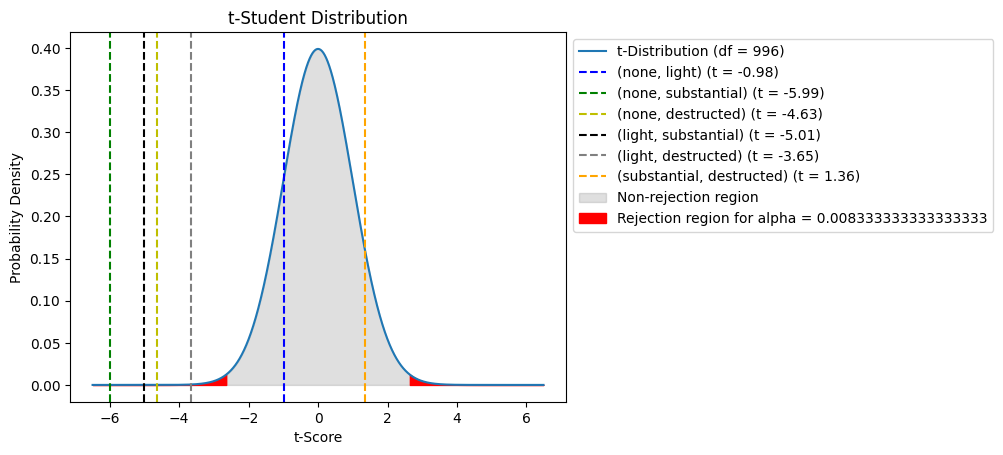

In [83]:
plot_t_student_distribution(t_scores, alpha_bonferroni, dfe, pairs)

**Final conclusion from ANOVA**

After applying the BONFERRONI correction and doing a t-test for each pair of damage level using the corrected $\alpha$ and df (degree of freedom), we can conclude that there is a significant difference in the average of age of airplanes between the following pairs of damage level:

- None vs Substantial
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **substantial damage** is greater than the ones with **none damage** according to the calculated point estimate.
- None vs Destructed
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **destructed damage** is greater than the ones with **none damage** according to the calculated point estimate.
- Light vs Substantial
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **substantial damage** is greater than the ones with **light damage** according to the calculated point estimate.
- Light vs Destructed
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **destructed damage** is greater than the ones with **light damage** according to the calculated point estimate.


Regarding the other pairs **(Substantial, Destructed)** and **(Light, None)**, as we have not rejected the null hypothesis, we can conclude nothing, neither if there is nor there is no difference between their averages of airplane ages.

**Confirming rapidly the ANOVA results applying Kruskal-Wallis test (Non-parametric)**

In [84]:
from scipy.stats import f_oneway, kruskal

alpha_kruskal = 0.05
h_score, p_value_kruskal = kruskal(ages_none, ages_light, ages_substantial, ages_destructed)
print(f"H-score gotten from kruskal: {f_score}\n")

if p_value_kruskal < alpha_kruskal:
    print(f"For a p-value = {p_value_kruskal} and alpha = {alpha_kruskal} we REJECT the null hypothesis!")
else:
    print(f"For a p-value = {p_value_kruskal} and alpha = {alpha_kruskal} we DO NOT REJECT the null hypothesis!")

H-score gotten from kruskal: 17.209769061785043

For a p-value = 2.601857978689584e-12 and alpha = 0.05 we REJECT the null hypothesis!


In [85]:
joined_samples = pd.concat([sample_category_none, 
                            sample_category_light,
                            sample_category_substancial, 
                            sample_category_destructed], axis=0)
#joined_samples.columns
kruskal_result = posthoc_dunn(joined_samples, val_col="idade_aeronave", 
             group_col="aeronave_nivel_dano", p_adjust = 'bonferroni') < 0.0083

print("Table obtained from pairwise Dunn's Test with BONFERRONI correction, \nafter rejecting the Kruskal test.")
kruskal_result

Table obtained from pairwise Dunn's Test with BONFERRONI correction, 
after rejecting the Kruskal test.


,DESTRUÍDA,LEVE,NENHUM,SUBSTANCIAL
DESTRUÍDA,False,True,True,False
LEVE,True,False,False,True
NENHUM,True,False,False,True
SUBSTANCIAL,False,True,True,False


True values indicate which pairs are different in terms of rank sums from each other. Looking at the table above, we can confirm the same results obtained using ANOVA relaxing the normality condition.

#### 4.3

**Checking Hypothesis:**


> Is proportion of airplanes with greater than or equal 11 years which had substantial damage in the occurrences significantly greater than proportion of airplanes with less than 11 years?



In [86]:
# taking broad samples
SAMPLE_SIZE_DAMAGE = 100
less_11_2 = dados[dados["tipo_aeronave"] == 'New'].copy()

more11_2 = dados[dados["tipo_aeronave"] == 'Old'].copy()
more11_2

,aeronave_ano_fabricacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_area,ocorrencia_classificacao,ocorrencia_dia,idade_aeronave,ocorrencia_longitude,ocorrencia_latitude,ocorrencia_hora,timestamp,quartis_idade,tipo_aeronave
codigo_ocorrencia,,,,,,,,,,,,,
45390,1989.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,20/01/2012,23.0,-49.4430555556,-18.4319444444,21:00:00,2012-01-20 21:00:00,"[12, 25)",Old
45390,1989.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,20/01/2012,23.0,-49.4430555556,-18.4319444444,21:00:00,2012-01-20 21:00:00,"[12, 25)",Old
45392,2000.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,19/01/2012,12.0,-47.8747222222,-15.8197222222,21:30:00,2012-01-19 21:00:00,"[12, 25)",Old
45392,2000.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,19/01/2012,12.0,-47.8747222222,-15.8197222222,21:30:00,2012-01-19 21:00:00,"[12, 25)",Old
45392,2000.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,19/01/2012,12.0,-47.8747222222,-15.8197222222,21:30:00,2012-01-19 21:00:00,"[12, 25)",Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-12-07 14:00:00,"[25, 39)",Old
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-12-07 14:00:00,"[25, 39)",Old
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-12-07 14:00:00,"[25, 39)",Old


*Notice:*
*   $p \leq 11$ represents the proportion of airplanes with less or equal 11 years which had substantial damage in the occurrences.
*   $p \gt 11$ represents the proportion of airplanes with more than 11 years which had substantial damage in the occurrences.

**Hypothesis Formulation**

$H_0$: There **IS NO** difference between proportions of airplanes with less than or equal 11 years and more than 11 years which had substantial damage.


> $p_{\gt 11} − p_{\leq 11} = 0$


$H_A$: There **IS** difference between proportions of airplanes with less than or equal 11 years and more than 11 years which had no damage.


> $p_{\gt 11} − p_{\leq 11} ≠ 0$

**Checking conditions for the sampling distribution of p̂1 − p̂2 to be normal:**

1.   **Independence**

* Because the data come from a simple random sample,
the observations are independent, both within and between samples.

2.   **Success-failure condition**

* Since the null hypothesis is that the proportions are equal, we use the pooled proportion ($p̂_{pooled}$)
to verify the success-failure condition and estimate the standard error.
* $p_{pooled} = \sqrt{\frac{{(p̂_1  n_1) + (p̂_2  n_2)}}{{n_1 + n_2 }}}$
* $n_1 * p̂_{pooled} \geq 10$ and $n_1 * (1-p̂_{pooled}) \geq 10$
* $n_2 * p̂_{pooled} \geq 10$ and $n_2 * (1-p̂_{pooled}) \geq 10$

In [87]:
p_hat_less11_2 = less_11_2["aeronave_nivel_dano"].value_counts(normalize=True).SUBSTANCIAL

print(f"For a sample size n1 = {SAMPLE_SIZE_DAMAGE}")
print("p-hat less than or equal 11 =", p_hat_less11_2)

For a sample size n1 = 100
p-hat less than or equal 11 = 0.5745937961595273


In [88]:
p_hat_more11_2 = more11_2["aeronave_nivel_dano"].value_counts(normalize=True).SUBSTANCIAL

print(f"For a sample size n2 = {SAMPLE_SIZE_DAMAGE}")
print("p-hat more than or equal 11 =", p_hat_more11_2)

For a sample size n2 = 100
p-hat more than or equal 11 = 0.6657274590163934


In [89]:
p_pooled_2 = (p_hat_less11_2 * SAMPLE_SIZE_DAMAGE + p_hat_more11_2 * SAMPLE_SIZE_DAMAGE) / (SAMPLE_SIZE_DAMAGE + SAMPLE_SIZE_DAMAGE)
print("p-hat pooled =", p_pooled_2)

p-hat pooled = 0.6201606275879604


In [90]:
ck1_2 = p_pooled_2 * SAMPLE_SIZE_DAMAGE
ck2_2 = (1 - p_pooled_2) * SAMPLE_SIZE_DAMAGE

if ck1_2 >= 10 and ck2_2 >= 10:
    print("Conditions 𝑛1 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛1 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

ck3_2 = p_pooled_2 * SAMPLE_SIZE_DAMAGE
ck4_2 = (1 - p_pooled_2) * SAMPLE_SIZE_DAMAGE

if ck3_2 >= 10 and ck4_2 >= 10:
    print("Conditions 𝑛2 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛2 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

Conditions 𝑛1 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!
Conditions 𝑛2 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!


**As both conditions are satisfied, we can safely model the difference in proportions using a normal distribution!**


$SE = \sqrt{\frac{{p̂_{pooled} * (1-p̂_{pooled})}}{{n_1}} + \frac{{p̂_{pooled} * (1-p̂_{pooled})}}{{n_2}}}$

In [91]:
SE_2 = sqrt(p_pooled_2*(1 - p_pooled_2) / len(less_11_2) + p_pooled_2*(1 - p_pooled_2) / len(more11_2))
print("SE =", SE_2)

SE = 0.015307283981785703


$point \ estimate =  p̂_{\gt 11} - p̂_{\leq 11}$

In [92]:
point_estimate_2 = p_hat_more11_2 - p_hat_less11_2
print("Point estimate =", point_estimate_2)

Point estimate = 0.09113366285686608


In [93]:
null_value_2 = 0     # it comes from the null hypothesis, since we are considering the difference between proportions 0
print("Null value =", null_value_2)
print("It comes from the null hypothesis, since we are considering the difference between proportions 0")

Null value = 0
It comes from the null hypothesis, since we are considering the difference between proportions 0



$Z^{*} = \frac{{\text{point estimate} - \text{null value}}}{{SE}}$

In [94]:
z_score_2 = (point_estimate_2 - null_value_2) / SE_2
print("Test statistic (Z*) =", z_score_2)

Test statistic (Z*) = 5.953614172527732


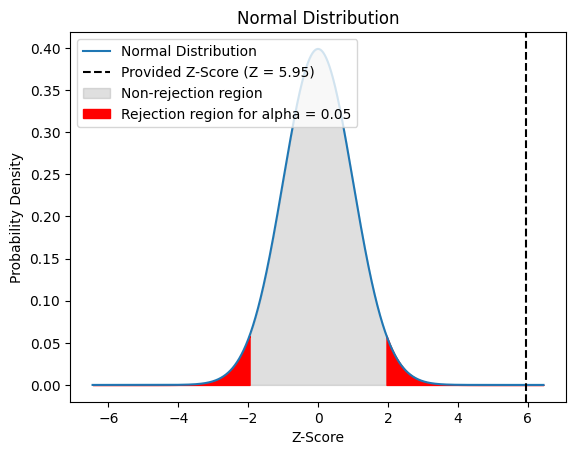

In [95]:
plot_normal_distribution(z_score_2, alpha=0.05)

In [96]:
# p_value is calculate for one-tail and we are using two-tails
# because of this we must double the value encountered
p_value_2 = stats.norm.sf(abs(z_score_2)) * 2
alpha_2 = 0.05

if p_value_2 < alpha_2:
    print(f"For a p-value = {p_value_2} and alpha = {alpha_2} we REJECT the null hypothesis!")
else:
    print(f"For a p-value = {p_value_2} and alpha = {alpha_2} we DO NOT REJECT the null hypothesis!")

For a p-value = 2.6228472892037336e-09 and alpha = 0.05 we REJECT the null hypothesis!


#### 4.4

**Checking Hypothesis:**

> Is there a significant relationship between the occurrence factor and the age of the aircraft?

**Hypothesis Formulation**
*   $H_0$: The age of aircraft is independent of the area factor (there is no significant association).

*   $H_A$: The age of aircraft is dependent on the area factor (there is a significant association).


**Organization of Data in a Contingency Table**

In [132]:
SAMPLE_SIZE_CHI2 = 3000
dados_sample_chi2 = dados.sample(n=SAMPLE_SIZE_CHI2, replace=False, axis=0)

tabela_contingencia = pd.crosstab(dados_sample_chi2['fator_area'], dados_sample_chi2['tipo_aeronave'])
tabela_contingencia


tipo_aeronave,New,Old
fator_area,,
FATOR HUMANO,276,759
FATOR MATERIAL,12,13
FATOR OPERACIONAL,443,1428
OUTRO,23,46


**Checking Conditions For The Chi-Square Test**

1.   **Independence**


*   Each case that contributes to a count to the table is independent of all the other cases in the table and between each other.



2.  **Sample size / distribution**


*  Each particular scenario have at least 5 expected cases

In [133]:
table = tabela_contingencia.values

def check_sample_size_distribution(table):
    # Checks whether each scenario has at least 5 expected cases
    for i in range(table.shape[0]):
        for j in range(table.shape[1]):
            value = table[i, j]
            if value < 5:
                return False
    return True

# Check conditions
independence_condition = "Since each table are independent, True"
sample_size_condition = check_sample_size_distribution(table)

# View results
print(f'Independence Condition: {independence_condition}')
print(f'Sample Size/Distribution Condition: {sample_size_condition}')


Independence Condition: Since each table are independent, True
Sample Size/Distribution Condition: True


**As both conditions are satisfied, we can safely we can implement chi-square test without problems.**

**Chi-Square Calculation**


$χ² = Σ [(O_{ij} - E_{ij})^² / E_{ij}]$
<br><br>

Where,

* $O_{ij}$ is the observed number of cases in cell $(i, j)$.

* $E_{ij}$ is the expected number of cases in cell $(i, j)$.






In [134]:
qui_quadrado_obs = 0

# Loop para calcular o Qui-Quadrado Observado
for i in range(tabela_contingencia.shape[0]):
    for j in range(tabela_contingencia.shape[1]):
        O = tabela_contingencia.iloc[i, j]  # Valor observado
        soma_linha = tabela_contingencia.iloc[i, :].sum()
        soma_coluna = tabela_contingencia.iloc[:, j].sum()
        E = (soma_linha * soma_coluna) / tabela_contingencia.sum().sum()  # Valor esperado
        qui_quadrado_obs += ((O - E)**2) / E

print(tabela_contingencia)
print(f"\nChi-Squared observed for the contigency table above: {qui_quadrado_obs}")

tipo_aeronave      New   Old
fator_area                  
FATOR HUMANO       276   759
FATOR MATERIAL      12    13
FATOR OPERACIONAL  443  1428
OUTRO               23    46

Chi-Squared observed for the contigency table above: 12.814461813775932


**Degrees of Freedom For a Two-Way Table**

$df=(R-1)*(C-1)$  

Where, $R$ is the number of rows in the table and $C$ is the number of columns.

In [135]:
df = (4 - 1) * (2 - 1)
print(f"Degrees of Freedom for the Two-Way Table in evidency: {df}")

Degrees of Freedom for the Two-Way Table in evidency: 3


In [136]:
# Significance Level (α)
alpha = 0.05

# Find the critical value
critical_value = chi2.ppf(1 - alpha, df)

print(f'Critical value for α = {alpha} and df = {df}: {critical_value}')

Critical value for α = 0.05 and df = 3: 7.814727903251179


In [138]:
print(f"Chi-square observed = {qui_quadrado_obs}")
print(f"Critical value = {critical_value}")
print()

if qui_quadrado_obs > critical_value:
    print("Reject H0, since the observed chi-squared is greater than the critical value.")
else:
    print("DO NOT Reject H0, since the observed chi-squared is NOT greater than the critical value")

Chi-square observed = 12.814461813775932
Critical value = 7.814727903251179

Reject H0, since the observed chi-squared is greater than the critical value.


**P-Value Calculation**

In [139]:
chi2_stat, p_value, dof, expected_freq = chi2_contingency(tabela_contingencia)

print("chi2_stat gotten after applying the chi-square test to the contigency table:\n")
print(f'chi2_stat = {chi2_stat}')

chi2_stat gotten after applying the chi-square test to the contigency table:

chi2_stat = 12.814461813775932


In [140]:
if p_value < 0.05:
    print(f'The p-value is {p_value}. \n\nSince the p-value is less than alpha({alpha}), \nthere is additional statistical evidence to reject the null hypothesis.')
else:
    print(f'The p-value is {p_value}. \n\nSince the p-value is less than alpha=({alpha}), \nthere is not additional statistical evidence to reject the null hypothesis.')

The p-value is 0.005055515691550064. 

Since the p-value is less than alpha(0.05), 
there is additional statistical evidence to reject the null hypothesis.


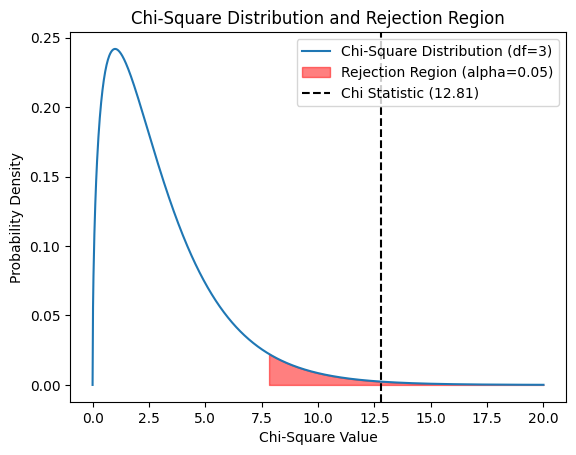

In [141]:
plot_chi_square_distribution(chi2_stat, dof, alpha)

#### 4.5

**Checking Hypothesis:**

> Are older aircraft more susceptible to accidents due to wind speed?



**Hypothesis Formulation**


$H_0$: The average wind speed in accidents involving old and new aircraft is not different.



> $\mu_{new} -\mu_{old} = 0$, where $\mu_{new}$ represents new airplanes average and $\mu_{old}$ represents old airplanes average.




$H_A$: The average wind speed in accidents involving old and new aircraft is different.


>  $\mu_{new} -\mu_{old} \neq 0$



**Checking conditions using the t-distribution for a difference in means**



1.   **Independence extended**

* The data are independent within and between the groups, since we are taking simple random samples.

2.   **Normality**

* We check the outliers rules of thumb for each group separately and there is no clear outliers in the data as can be seen in the chart below.

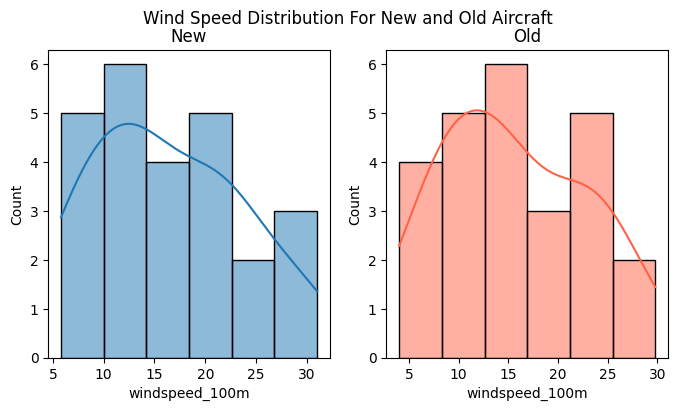

In [106]:
SAMPLE_SIZE_WIND = 25
wind_newer = new["windspeed_100m"].sample(n=SAMPLE_SIZE_WIND, replace=False, axis=0)
wind_older = old["windspeed_100m"].sample(n=SAMPLE_SIZE_WIND, replace=False, axis=0)

fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.histplot(wind_newer, ax=axs[0], kde=True)
sns.histplot(wind_older, ax=axs[1], kde=True, color="tomato")
plt.suptitle("Wind Speed Distribution For New and Old Aircraft")
axs[0].set_title("New")
axs[1].set_title("Old")
plt.show()

confidence_level = 0.95

# Calculate the sample means
mean_wind_newer = np.mean(wind_newer)
mean_wind_older = np.mean(wind_older)

**Standard Error Calculate**

$SE=\sqrt{\frac{{s_1^2}}{{n_1}} + \frac{{s_2^2}}{{n_2}}}$

In [107]:
# Calculate the standard errors
std_newer_wind = np.std(wind_newer)
std_older_wind = np.std(wind_older)

se_wind = sqrt((std_newer_wind ** 2) / SAMPLE_SIZE_WIND + (std_older_wind ** 2) / SAMPLE_SIZE_WIND)

print(f"For n1 = n2 = {SAMPLE_SIZE_WIND}\n"
      f"std_new = {std_newer_wind}\n"
      f"std_old = {std_older_wind}\n")
print("SE =", se_wind)

For n1 = n2 = 25
std_new = 7.18469038998898
std_old = 7.064937650114118

SE = 2.0152728847478696


$point \ estimate = x̄_{new} - x̄_{old}$

In [108]:
pe_wind = mean_wind_newer - mean_wind_older
print("Point estimate =", pe_wind)

Point estimate = 0.7839999999999971


**Confidence Interval**

$CI = point \ estimate \ ± \ t^*_{df} \ * \ SE$

Using a confidence level of 0.95 we should get the $t^*_{df}$ using software or a table. 

In [109]:
# We use 0.025 because we are calculating for two tails
# and this method consider that it is one tail.
# So, 0.05 for two tails is 0.025 for each tail
# which means that for one tail we should calculate with 0.025
t_score_ci_wind = stats.t.isf(alpha/2, df=SAMPLE_SIZE_WIND - 1)
print("Test statistic for the confidence interval 95%:")
print(t_score_ci_wind)

Test statistic for the confidence interval 95%:
2.063898561628021


In [110]:
lower_limit_wind_diff = pe_wind - abs(t_score_ci_wind) * se_wind
upper_limit_wind_diff = pe_wind + abs(t_score_ci_wind) * se_wind
CI = (lower_limit_wind_diff, upper_limit_wind_diff)

print("95% Confidence Interval for the wind average difference among new and old aircraft:")
print()
print(CI)

95% Confidence Interval for the wind average difference among new and old aircraft:

(-3.3753188081190837, 4.943318808119078)


## **5. Conclusion**

**4.1**  

Since we have rejected the null hypothesis, we can conclude that there is a difference in the proportion of occurrences classified as **accidents** between older aircraft and newer ones. 

Furthermore, based on the confidence interval, we can also confirm with a 95% confidence level that older aircraft tend to have between 6.1 to 23.23 percentage points greater number of accidents than newer ones.

**4.2**

After applying the BONFERRONI correction and doing a t-test for each pair of damage level using the corrected $\alpha$ and df (degree of freedom), we can conclude that there is a significant difference in the average of age of airplanes between the following pairs of damage level:

- None vs Substantial
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **substantial damage** is greater than the ones with **none damage** according to the calculated point estimate.
- None vs Destructed
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **destructed damage** is greater than the ones with **none damage** according to the calculated point estimate.
- Light vs Substantial
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **substantial damage** is greater than the ones with **light damage** according to the calculated point estimate.
- Light vs Destructed
    - We can even conclude that the direction of the difference between them is that the average of airplane's ages with **destructed damage** is greater than the ones with **light damage** according to the calculated point estimate.


Regarding the other pairs **(Substantial, Destructed)** and **(Light, None)**, as we have not rejected the null hypothesis, we can conclude nothing, neither if there is nor there is no difference between their averages of airplane ages.

We also have confirmed the same results using the Kruskal-Wallis test followed by pairwise Dunn's test, which are more appropriated when the normality condition is not respected.

**4.3**

Since we have rejected the null hypothesis, we can conclude that **there is** difference between proportions of newer and older airplanes which had **substantial damages**.

Furthermore, the point estimate indicate that the direction of that difference is that older airplanes have proportions of occurrences with substantial damage greater newer ones.

**4.4**

In the “significant relationship between the occurrence factor and the age of the aircraft” analysis, since we have rejected the null hypothesis, we can conclude that there is a significant relationship between the age of the aircraft and the factor of occurrences. In addition, analyzing the heatmap, we can see in which pairs there’s a stronger relationship.

**4.5**

Since the confidence interval **contain the 0 value**, we CANNOT reject with a 95.0% confidence level that the means of the wind speed, when the occurrences had happened, for older and newer aircraft are different.

*by Ingrid Diniz, Igor Diniz e José Santos*